Flip image to get more training data (Aeffectilfe [..] without keypoints)


# Head pose estimation

Names: Javier Covas Llompart, Lukas Koberg

The goal is to develop a neural notwork, that is able to detect the pose of a head (the 3 angles). Therfor pytorch is used.
this file is used to work with the 300W-LP dataset

## Setup

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision.models import resnet50, resnet152
from torchvision.transforms.functional import pil_to_tensor
from PIL import Image
import scipy.io as sio
import torchvision.transforms as T
import os
import glob
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#from google.colab import drive
#drive.mount('/content/gdrive/', force_remount=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [2]:
basepath = "Advanced Topics Computer Vision/Short Project/"

In [3]:
basepath = "E:/Code/Head_pose/Data/"

In [4]:
def compute_euler_angles_from_rotation_matrices(rotation_matrices, full_range=False):
    batch = rotation_matrices.shape[0]
    R = rotation_matrices
    sy = torch.sqrt(R[:,0,0]*R[:,0,0]+R[:,1,0]*R[:,1,0])
    singular = sy<1e-6
    singular = singular.float()

    '''2023.01.15'''
    for i in range(len(sy)):  # expand y (yaw angle) range into (-180, 180)
        if R[i, 0, 0] < 0 and full_range:
            sy[i] = -sy[i]

    x = torch.atan2(R[:,2,1], R[:,2,2])
    y = torch.atan2(-R[:,2,0], sy)
    z = torch.atan2(R[:,1,0],R[:,0,0])

    xs = torch.atan2(-R[:,1,2], R[:,1,1])
    ys = torch.atan2(-R[:,2,0], sy)
    zs = R[:,1,0]*0

    gpu = rotation_matrices.get_device()
    if gpu < 0:
        out_euler = torch.autograd.Variable(torch.zeros(batch,3)).to(torch.device('cpu'))
    else:
        out_euler = torch.autograd.Variable(torch.zeros(batch,3)).to(torch.device('cuda:%d' % gpu))
    out_euler[:,0] = x*(1-singular)+xs*singular
    out_euler[:,1] = y*(1-singular)+ys*singular
    out_euler[:,2] = z*(1-singular)+zs*singular
    # print('out_euler', out_euler)

    return out_euler

In [5]:
def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]
    return pose_params

## Load Datasets and Preperation

In [6]:
class D300W_LP_Dataset(Dataset):
    def __init__(self): #Example code
        # convert into PyTorch tensors and remember them
        
        self.X = self.read_data()[0]
        self.y = self.read_data()[1]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, train_size=0.7, shuffle=True)

    def __len__(self):
        # this should return the size of the dataset
        return len(self.X_train)

    def __getitem__(self, idx):
        # this should return one sample from the dataset
        #features = pil_to_tensor(Image.open(self.X[idx])).float()
        target_height = 100
        img = Image.open(self.X_train[idx])
        width, height = img.size
        new_width = int(width * (target_height / height))
        #img = img.resize((new_width, target_height))
        features = self.transform(img)
        target = torch.tensor(self.y_train[idx][0]).unsqueeze(0)
        return features, target
    
    def get_test_item(self, idx):
        # this should return one sample from the dataset
        #features = pil_to_tensor(Image.open(self.X[idx])).float()
        target_height = 50
        img = Image.open(self.X_test[idx])
        width, height = img.size
        new_width = int(width * (target_height / height))
        features = self.transform(img)
        target = self.y_test[idx, 1]
        return features, target
    
    transform = T.Compose([
        #T.ToPILImage(),
        #T.Resize(([64, 49])),
        T.ToTensor()])
    
    def read_data(self):
        list_angle_data = []
        list_picture_data = []

        #folder_nr = "01"
        os.chdir(basepath + "300W_LP/")
        for file in glob.glob("**/*.jpg", recursive=True):
            #print(file)
            file = file.replace("\\", "/")
            angles = get_ypr_from_mat(basepath + "300W_LP/" + file.split(".")[0] + ".mat")
            list_picture_data.append(basepath + "300W_LP/"+ file)
            list_angle_data.append(angles)

        #print((np.stack(list_angle_data, axis=0).shape))
        #print(angles*180/np.pi)
        return list_picture_data, list_angle_data


In [115]:
#dataset = D300W_LP_Dataset()
#print(dataset.__getitem__(11))
#plt.hist(dataset.y)

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), tensor([-0.5655]))


(array([469., 473., 471., 411., 202., 167., 336., 371., 363., 381.]),
 array([-1.57069509e+00, -1.25673145e+00, -9.42767801e-01, -6.28804156e-01,
        -3.14840512e-01, -8.76867367e-04,  3.13086777e-01,  6.27050421e-01,
         9.41014066e-01,  1.25497771e+00,  1.56894135e+00]),
 <BarContainer object of 10 artists>)

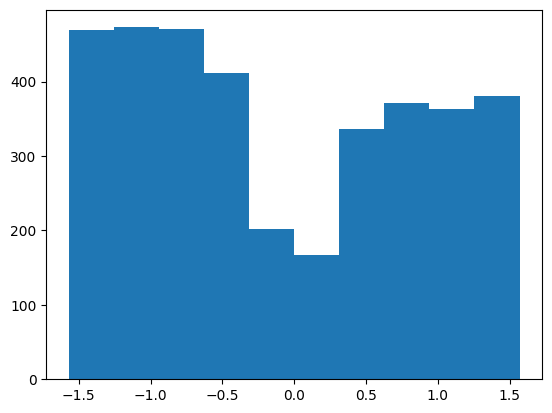

In [119]:
plt.hist([angles[1] for angles in dataset.y_train])

torch.Size([450, 450, 3])


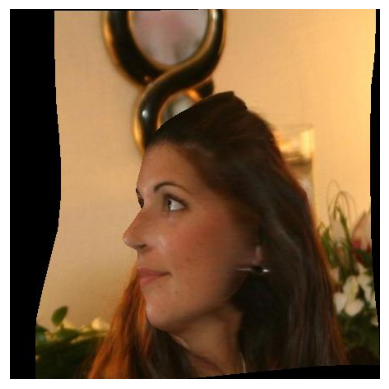

In [120]:
reshaped_image = dataset.__getitem__(0)[0].permute(1, 2, 0)
print(reshaped_image.shape)
# Display the image using plt.imshow
plt.imshow(reshaped_image)
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
len(dataset.X_train)

## Model

- Oroginal paper based on RESNET!

In [7]:
resnet152_model = resnet152(pretrained=False)
class HeadPoseModel_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet152_model = resnet152_model
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(1000, 1000)
        self.act1 = nn.ReLU()
        self.linear2 = nn.Linear(1000, 1000)
        self.act2 = nn.ReLU()
        self.linear3 = nn.Linear(1000, 500)
        self.act3 = nn.ReLU()
        self.linear4 = nn.Linear(500, 1)

    def forward(self, x):
      x = self.resnet152_model(x)
      x = self.flatten(x)
      x = self.act1(self.linear1(x))
      x = self.act2(self.linear2(x))
      x = self.act3(self.linear3(x))
      x = self.linear4(x)
      return x

model = HeadPoseModel_1()
#print(model)
summary(model,(3,300,300))


e:\Programme\.conda\envs\CV_Head\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Programme\.conda\envs\CV_Head\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 1000]                --
|    └─Conv2d: 2-1                       [-1, 64, 150, 150]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 150, 150]        128
|    └─ReLU: 2-3                         [-1, 64, 150, 150]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 75, 75]          --
|    └─Sequential: 2-5                   [-1, 256, 75, 75]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 75, 75]         75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 75, 75]         70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 75, 75]         70,400
|    └─Sequential: 2-6                   [-1, 512, 38, 38]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 38, 38]         379,392
|    |    └─Bottleneck: 3-5              [-1, 512, 38, 38]         280,064
|    |    └─Bottleneck: 3-6              [-1, 512, 38, 38] 

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 1000]                --
|    └─Conv2d: 2-1                       [-1, 64, 150, 150]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 150, 150]        128
|    └─ReLU: 2-3                         [-1, 64, 150, 150]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 75, 75]          --
|    └─Sequential: 2-5                   [-1, 256, 75, 75]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 75, 75]         75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 75, 75]         70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 75, 75]         70,400
|    └─Sequential: 2-6                   [-1, 512, 38, 38]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 38, 38]         379,392
|    |    └─Bottleneck: 3-5              [-1, 512, 38, 38]         280,064
|    |    └─Bottleneck: 3-6              [-1, 512, 38, 38] 

## Train Models

In [8]:
# set up DataLoader for training set
dataset = D300W_LP_Dataset()
loader = DataLoader(dataset, shuffle=True, batch_size=10)

In [10]:
loss_fn = nn.MSELoss()  # Mean squered error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
n_epochs = 20
save_mode_path = "Models/model_2/model_checkpoint.pth"
model.train()
for epoch in range(n_epochs):
    for X_batch, y_batch in loader:
        #step = (epoch * len(loader)) + i + 1
        y_pred = model(X_batch)
        #print(y_pred.shape)
        #print(y_batch.shape)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Save the model's state_dict every 1000 steps
        #if step % 1000 == 0:
        #   pass
            #save_mode_path = "Models/model_1/model_checkpoint.pth"
            #torch.save(model.state_dict(), save_mode_path)
        print(f'latest loss {loss}')
    #print(f'{epoch}, step: {step}, latest loss {loss}')
    torch.save(model.state_dict(), save_mode_path)
    print(f'Finished epoch {epoch}, latest loss {loss}')

#save_mode_path = "Models/model_1/model_checkpoint.pth"
torch.save(model.state_dict(), save_mode_path)


latest loss 0.0589483268558979
latest loss 5.1551971435546875
latest loss 0.08588127046823502
latest loss 0.21430861949920654
latest loss 0.15363186597824097
latest loss 0.022763771936297417
latest loss 0.24099330604076385
latest loss 0.13699543476104736


RuntimeError: Found dtype Double but expected Float

### Load model

In [ ]:
# Initialize the model
model = HeadPoseModel_1()
# Load the saved state_dict
save_mode_path = "Models/model_2/model_checkpoint.pth"

model.load_state_dict(torch.load(save_mode_path))
# Set the model to evaluation mode
model.eval()

## Evaluate Model

In [ ]:
for i in range(0,100):
    y_pred = model(dataset.get_test_item(i)[0].unsqueeze(0))
    y_test =  dataset.get_test_item(i)[1].unsqueeze(0)
    acc = (y_pred.round() == y_test).float().mean()
    acc = float(acc)
    print("Model accuracy: %.2f%%" % (acc*100))
    print(f"{y_pred} truth: {y_test}")